In [1]:
# Import Libaries
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt


folder_dir = '/kaggle/input/flower-dataset/flowers'

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Collect Data

In [2]:
data = []
label = []

SIZE = 128 #Crop the image to 128x128

for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("jpg"):
            label.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (SIZE,SIZE))
            data.append(im)
        else:
            continue

In [3]:
data_arr = np.array(data)
label_arr = np.array(label)

## Label Data

In [4]:
# Set labels through encoding
encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y,5)
X = data_arr/255

## Split Data

In [5]:
# Split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)

# CNN Model

In [6]:
# Model layers
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (SIZE,SIZE,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(5, activation = "softmax"))

## Data Augmentation

In [7]:
# training data generator
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range = 0.20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        horizontal_flip=True,
        vertical_flip=True)

datagen.fit(X_train)

In [8]:
# train model on generated dataset
model.compile(optimizer=Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
batch_size=32
epochs=30
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs,
                              validation_data = (X_test,y_test),
                              verbose = 1)

Epoch 1/30


/tmp/ipykernel_255/1694850278.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),


108/108 [==============================] - 385s 4s/step - loss: 1.6090 - accuracy: 0.2754 - val_loss: 1.3897 - val_accuracy: 0.3935
Epoch 2/30
108/108 [==============================] - 382s 4s/step - loss: 1.4040 - accuracy: 0.3739 - val_loss: 1.2764 - val_accuracy: 0.4560
Epoch 3/30
108/108 [==============================] - 382s 4s/step - loss: 1.2791 - accuracy: 0.4387 - val_loss: 1.1508 - val_accuracy: 0.4815
Epoch 4/30
108/108 [==============================] - 383s 4s/step - loss: 1.2366 - accuracy: 0.4686 - val_loss: 1.1644 - val_accuracy: 0.5301
Epoch 5/30
108/108 [==============================] - 381s 4s/step - loss: 1.2070 - accuracy: 0.4874 - val_loss: 1.2439 - val_accuracy: 0.4954
Epoch 6/30
108/108 [==============================] - 382s 4s/step - loss: 1.1693 - accuracy: 0.5109 - val_loss: 1.1954 - val_accuracy: 0.4514
Epoch 7/30
108/108 [==============================] - 382s 4s/step - loss: 1.1461 - accuracy: 0.5285 - val_loss: 1.1049 - val_accuracy: 0.5486
Epoch 8/30

# Data Visulization after Training

27/27 [==============================] - 25s 915ms/step


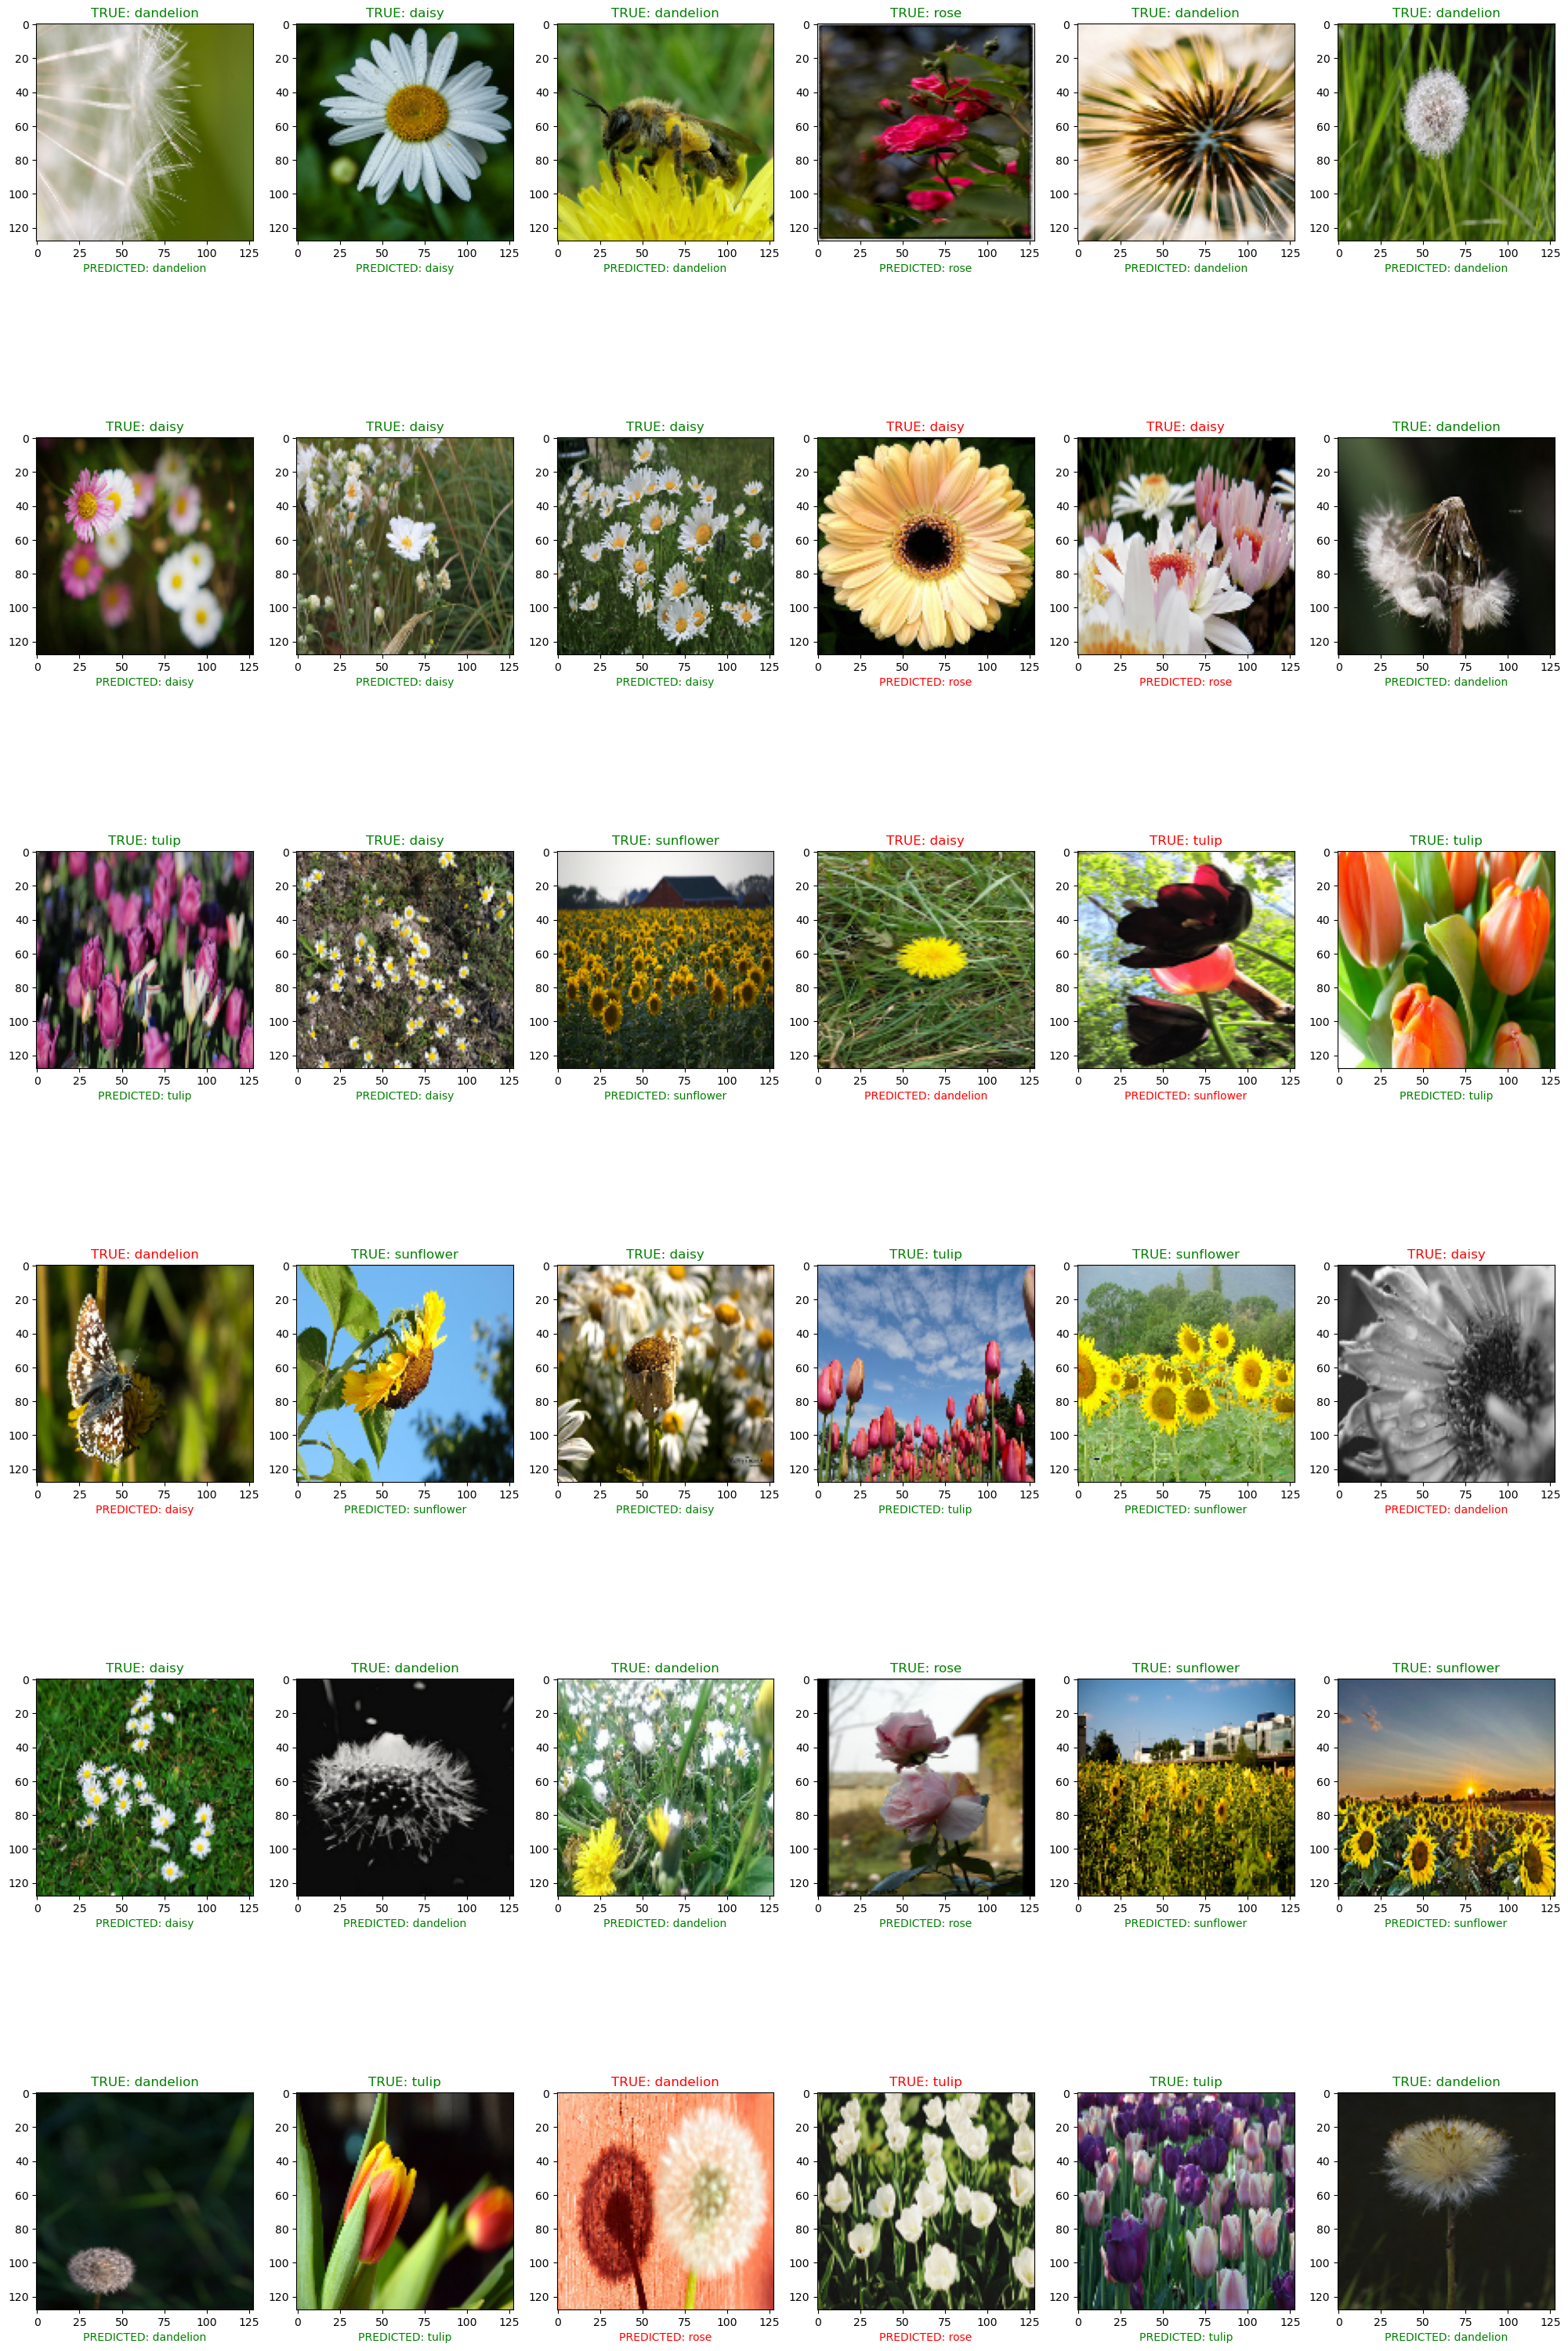

In [9]:
categories = np.sort(os.listdir(folder_dir))
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(X_test))
        if(categories[np.argmax(y_test[k])] == categories[np.argmax(model.predict(X_test)[k])]):
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='green')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')
        else:
            ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test[k])], color='red')
            ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            ax[i,j].imshow(np.array(X_test)[k].reshape(SIZE, SIZE, 3), cmap='gray')